# Exploratoy Data Analysis

## Prologue & Imports

In this notebook we will explore the data we scraped from the web using techniques such as data visualization and descriptive statistics. We will also look at the distribution of the data and the relationships between the features.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from octis.dataset.dataset import Dataset

from utils.data_loader import GreekPMDataloader
from models.octis.utils.preprocessor_gr import GreekStanzaPreprocessor
from models.octis.config.preprocessing import preprocessor_gr_params

from spacy.lang.el.stop_words import STOP_WORDS as el_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

2024-04-12 18:46:26 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-04-12 18:46:26 INFO: Downloaded file to /Users/dion/stanza_resources/resources.json
2024-04-12 18:46:26 WARNING: Language el package default expects mwt, which has been added
2024-04-12 18:46:26 INFO: Loading these models for language: el (Greek):
| Processor | Package                 |
---------------------------------------
| tokenize  | gdt                     |
| mwt       | gdt                     |
| pos       | models/oct..._tagger.pt |
| lemma     | models/oct...matizer.pt |

2024-04-12 18:46:26 INFO: Using device: cpu
2024-04-12 18:46:26 INFO: Loading: tokenize
2024-04-12 18:46:27 INFO: Loading: mwt
2024-04-12 18:46:27 INFO: Loading: pos
2024-04-12 18:46:27 INFO: Loading: lemma
2024-04-12 18:46:27 INFO: Done loading processors!


## Dataset Loading & Cleaning

Let's start by loading the scraped dataset and taking a look at the first few rows.

In [2]:
speeches_df = pd.read_csv('data/data_speeches.csv')
statements_df = pd.read_csv('data/data_statements.csv')
dataset_df = pd.concat([speeches_df, statements_df], ignore_index=True)

dataset_df['text'] = dataset_df['text'].astype(str) 
dataset_df.dropna(how='any', inplace=True)

dataset_df.to_csv('data/data_merged.csv', index=True)

In [3]:
try:
    dataset = Dataset()
    dataset.load_custom_dataset_from_folder('models/octis/data/dataset')
    print("Dataset found cached - loading...")
except:
    print("Dataset not found in cache - loading...")

    # We have some non-Greek stopwords in the dataset, so we need to remove them
    stopwords = set(el_stop).union(set(en_stop))
    
    # Initialize preprocessing
    preprocessor = GreekStanzaPreprocessor(
                             stopword_list=stopwords, 
                             **preprocessor_gr_params)
    
    # Create the dataset
    print("Preprocessing data...")
    dataset = preprocessor.preprocess_dataset(documents_path='data/data_merged.csv')
    
    dataset.save('models/octis/data/dataset/')
    print("Dataset preprocessed and saved!")

Dataset found cached - loading...


Let's gain some insights about our data. OCTIS does a train, validation and test split for us - we will use the training data for our EDA. Validation is only used if the model expects it, otherwise it is merged with the test data.

In [4]:
dataset.get_metadata()

{'total_documents': 2033,
 'vocabulary_length': 4475,
 'preprocessing-info': ['lowercase',
  'lemmatize',
  'filter words with document frequency lower than 0.01 and higher than 0.2',
  'filter words with less than 4 character',
  'remove_punctuation'],
 'last-training-doc': 1439,
 'last-validation-doc': 1599}

We see that we have `1449` documents for training.

In [5]:
last_training_idx = dataset.get_metadata()['last-training-doc']
corpus = dataset.get_corpus()

Since our dataset was disconnected from its original rows, we will use the saved indexes to merge the data back together for our EDA.

In [6]:
indexes = []
with open('models/octis/data/dataset/indexes.txt') as f:
    for line in f:
        indexes.append(int(line.strip()))

In [7]:
indexed_df = pd.DataFrame(columns=['original_index'])

for i, doc in enumerate(corpus):
    indexed_df = pd.concat([indexed_df, pd.DataFrame({'text': [corpus[i]], 'original_index': [indexes[i]]})])

In [8]:
indexed_df

original_index                                               text
0             960  [γιορτή, ορθοδοξία, σηματοδοτώ, διαχρονικά, δο...
0            1619  [σύνοδος, κορυφή, δίκαιος, απασχόληση, προσερχ...
0             589  [συνάδελφος, ομολογία, έντονος, προσωπικό, στί...
0            1804  [ανατολικός, δήμαρχος, δημοτικός, συνομιλώ, δή...
0             898  [ομόλογό, οδύνη, τρομοκρατικός, επίθεση, υπογρ...
..            ...                                                ...
0             328  [φεύγω, βράδυ, δημοκρατικός, φεύγω, ανανεώνω, ...
0            1980  [παρασκευή, ανταγωνιστικότητα, μεταφορά, δίκτυ...
0             698  [σύντροφος, τελικός, ευθεία, επίπονος, σκληρός...
0            1079  [χαρακτήρας, χρηματοδότηση, επτά, δήμος, δυτικ...
0            1358  [υποδέχομαι, χαρακτηρίζω, συνάντησή, επαφή, θε...

[1882 rows x 2 columns]

And we can now merge the data back together.

In [9]:
# rename text to original_text
dataset_df.rename(columns={'text': 'original_text'}, inplace=True)
data_df = dataset_df.merge(indexed_df, left_on=dataset_df.index, right_on='original_index')
data_df.drop(columns=['url', 'id'], inplace=True)

In [10]:
data_df.sample(3)

date                                              title  \
1099  2022-01-08  Ενημερωτικό σημείωμα για τις δηλώσεις του Πρωθ...   
1403  2020-05-19  Δήλωση του Πρωθυπουργού Κυριάκου Μητσοτάκη για...   
1564  2017-11-17  «Nα ανοίξουμε τον δρόμο για την προστασία του ...   

                                          original_text original_index  \
1099  «Οικοδομείται δυναμική για την επιστροφή των Γ...           1120   
1403  «Η είδηση του θανάτου του Ευγένιου Ρωσσίδη γεμ...           1437   
1564  Δήλωση του Πρωθυπουργού Αλέξη Τσίπρα κατά την ...           1618   

                                                   text  
1099  [μουσείο, αντίστοιχος, βρετανικός, μουσείο, φε...  
1403  [επικοινωνώ, κύκλος, αναμέτρηση, αφετηρία, επί...  
1564  [εξακολουθώ, εγείρω, συνείδηση, φωτίζω, πολυτε...

And filter the training data...

In [11]:
data_df = data_df[data_df.original_index <= last_training_idx]
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1406 entries, 0 to 1405
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            1406 non-null   object
 1   title           1406 non-null   object
 2   original_text   1406 non-null   object
 3   original_index  1406 non-null   object
 4   text            1406 non-null   object
dtypes: object(5)
memory usage: 65.9+ KB


We now can start the analysis on our training data.

## Analysis

Since we have dates, we can start by looking at the distribution of the years.

In [12]:
data_df['year'] = data_df['date'].apply(lambda x: x.split('-')[0])

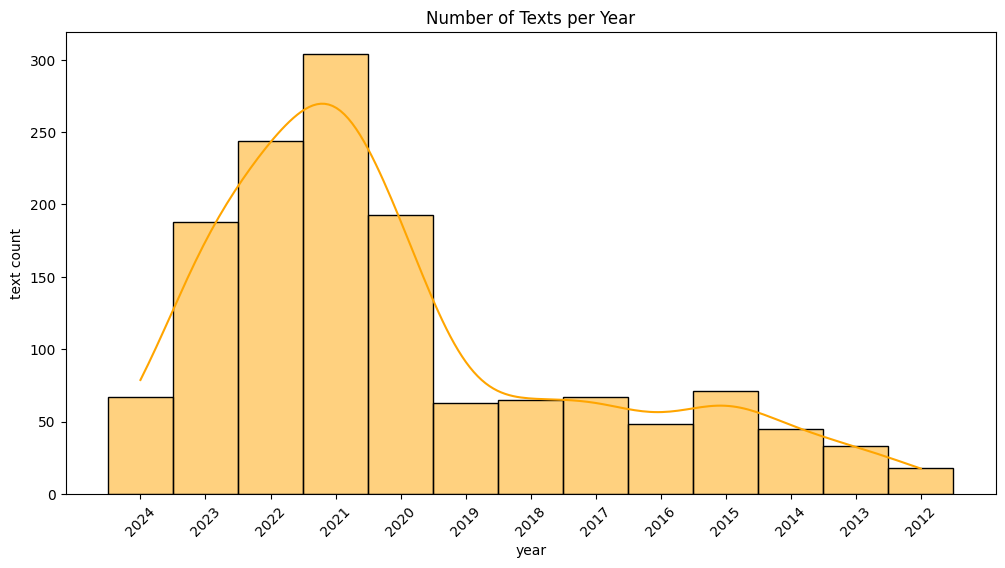

In [17]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data_df, x='year', bins=range(2000, 2023), kde=True, legend=False, color='orange')
plt.xticks(rotation=45)
plt.title('Number of Texts per Year')
plt.ylabel('text count')
plt.show()


Now let's look at the most popular words per year.

In [67]:
data_df["processed_text_str"] = data_df["text"].apply(lambda x: ' '.join(x))
data_df.sample(2)

date                                              title  \
1339  2020-10-21  Δήλωση του Πρωθυπουργού Κυριάκου Μητσοτάκη μετ...   
484   2018-11-16  «Το μέλλον της Βόρειας Ελλάδας της Μακεδονίας ...   

                                          original_text original_index  \
1339  Κύριοι Πρόεδροι κυρίες και κύριοι Ολοκληρώσαμε...           1367   
484   Ομιλία στην 3η Σύνοδο Thessaloniki Summit 2018...            487   

                                                   text  year  \
1339  [χαίρω, ενημερώνω, μέτωπο, κορωνοϊός, αντιμέτω...  2020   
484   [νομοσχέδιο, ασφαλιστικός, εισφορά, ελπίδα, νο...  2018   

                                     processed_text_str  
1339  χαίρω ενημερώνω μέτωπο κορωνοϊός αντιμέτωπος κ...  
484   νομοσχέδιο ασφαλιστικός εισφορά ελπίδα νομοσχέ...

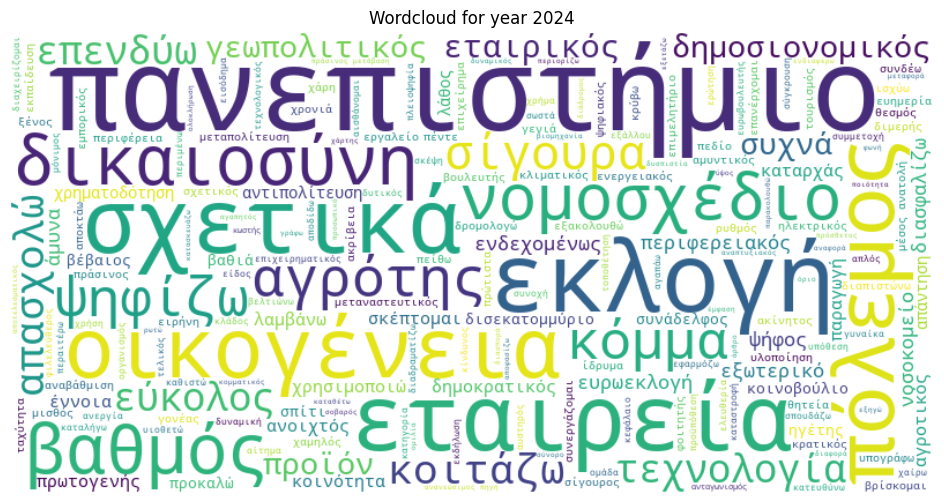

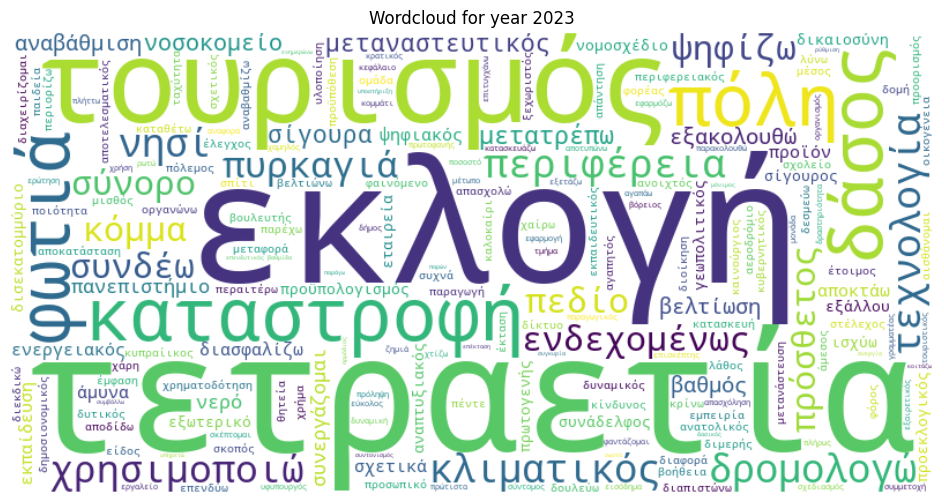

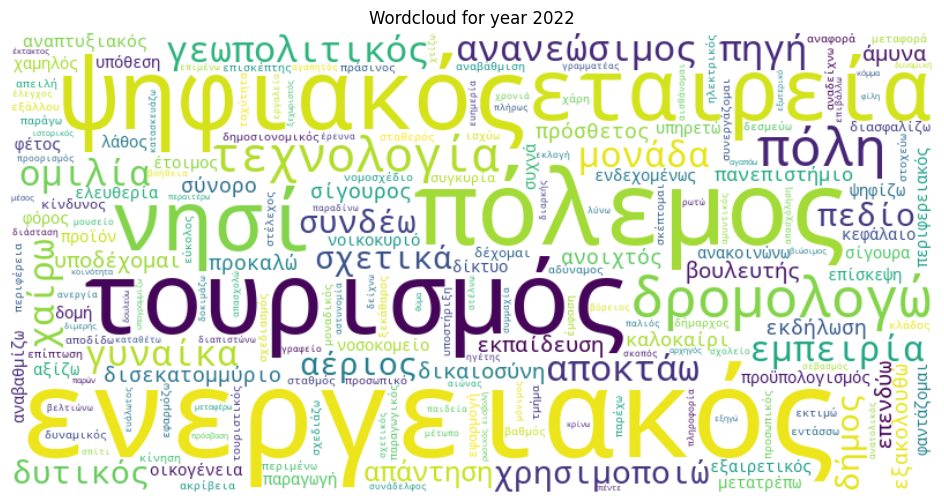

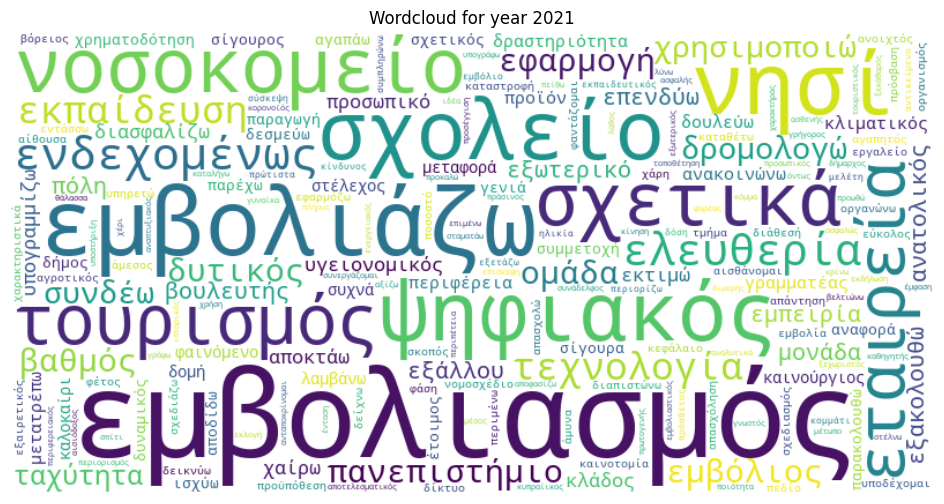

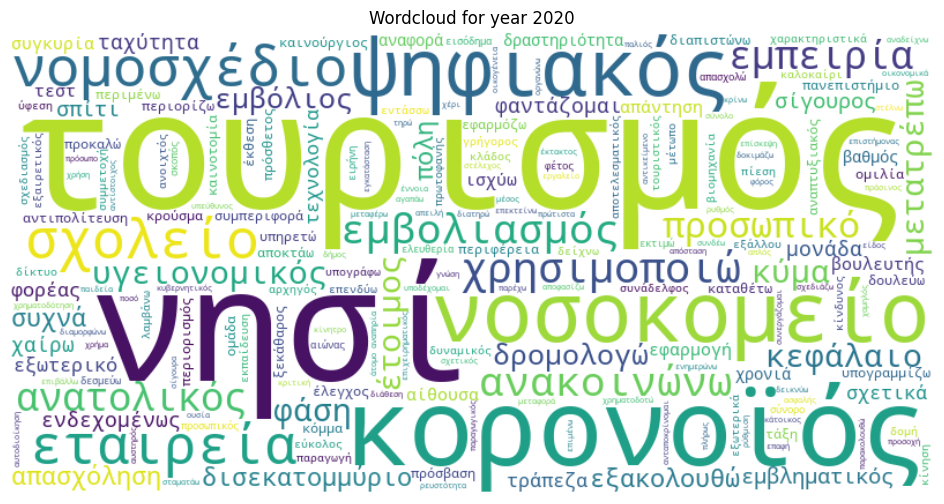

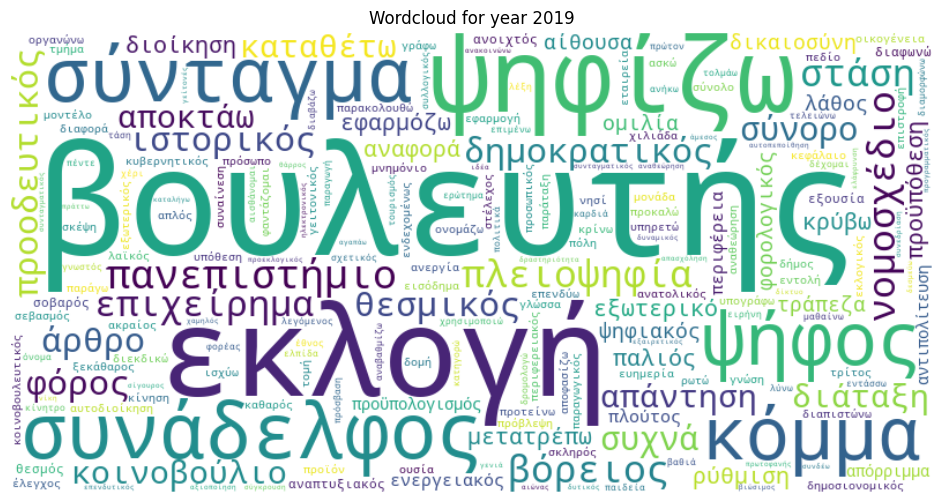

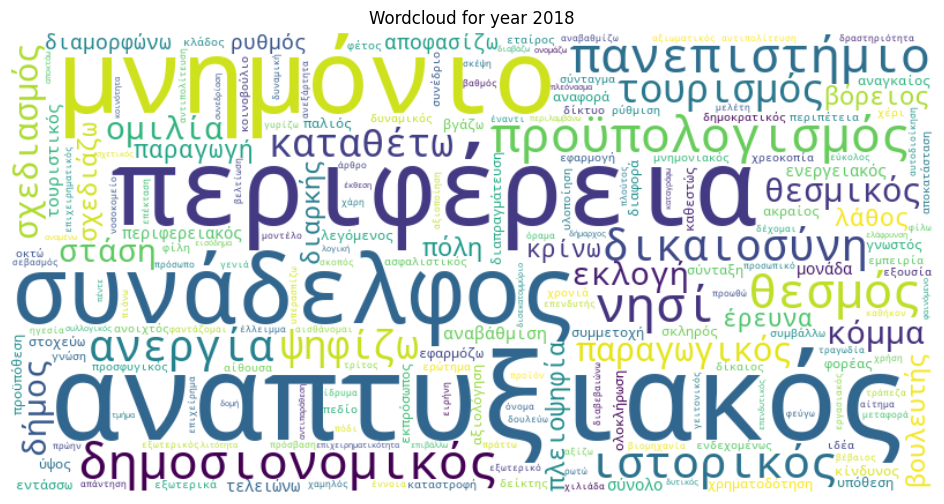

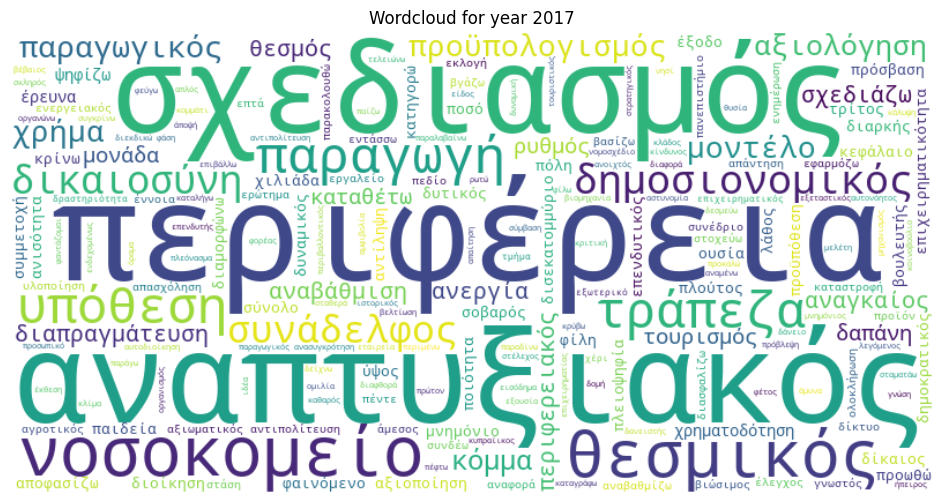

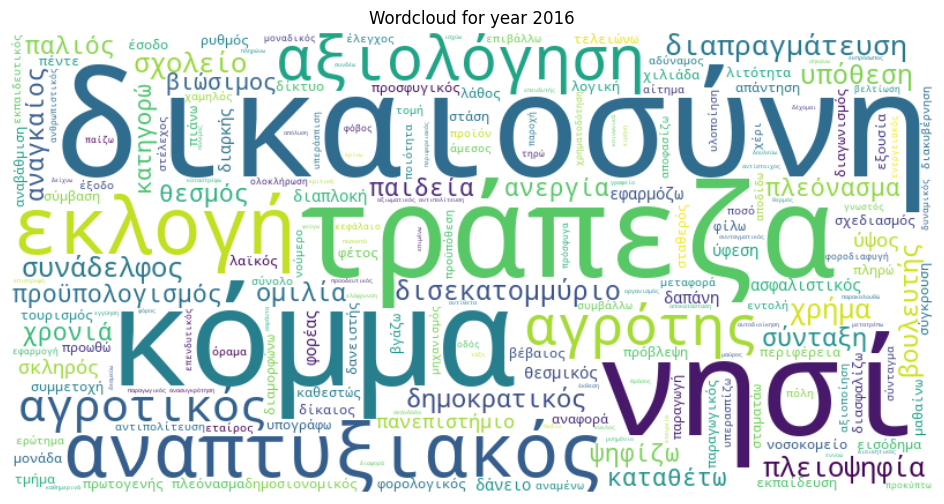

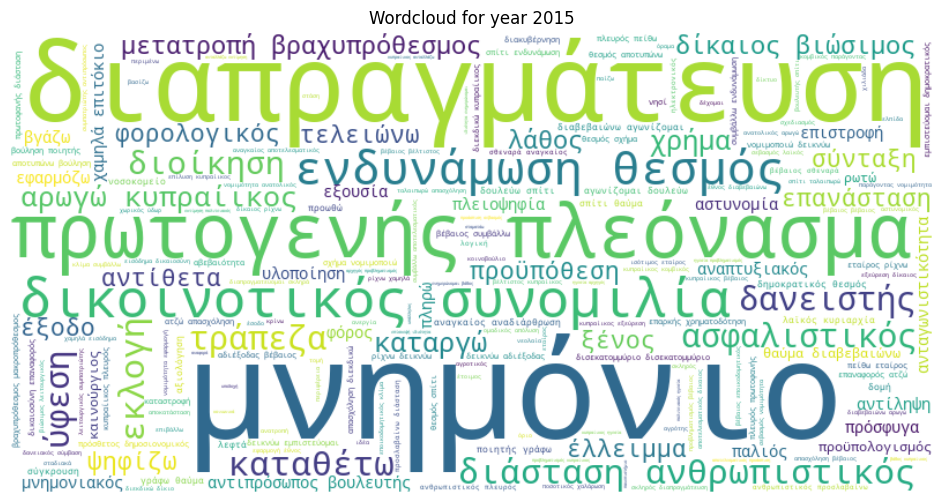

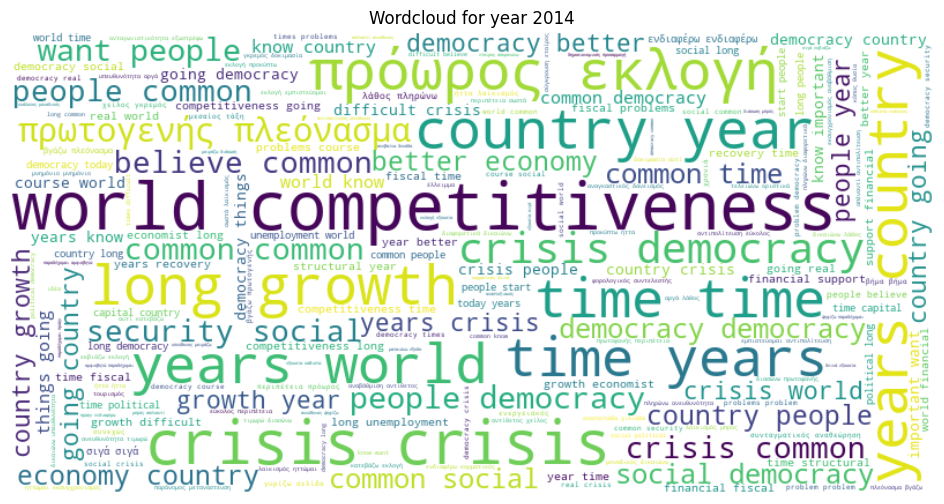

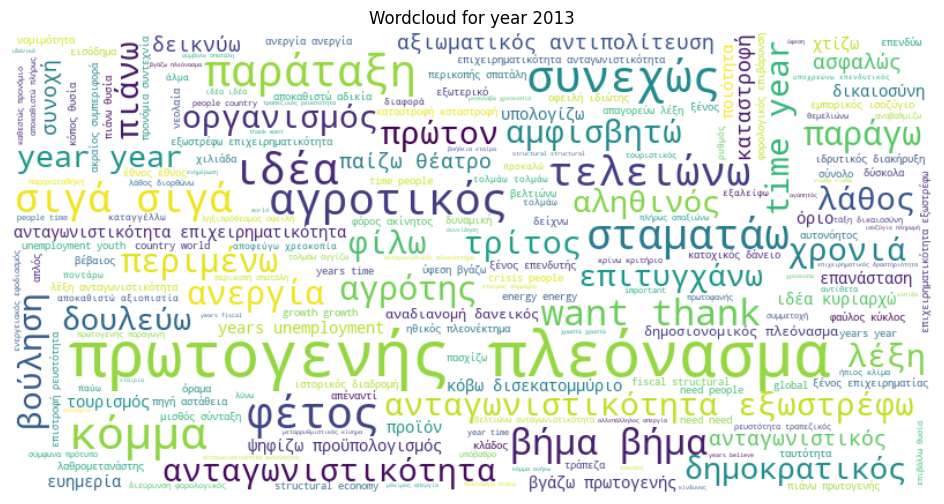

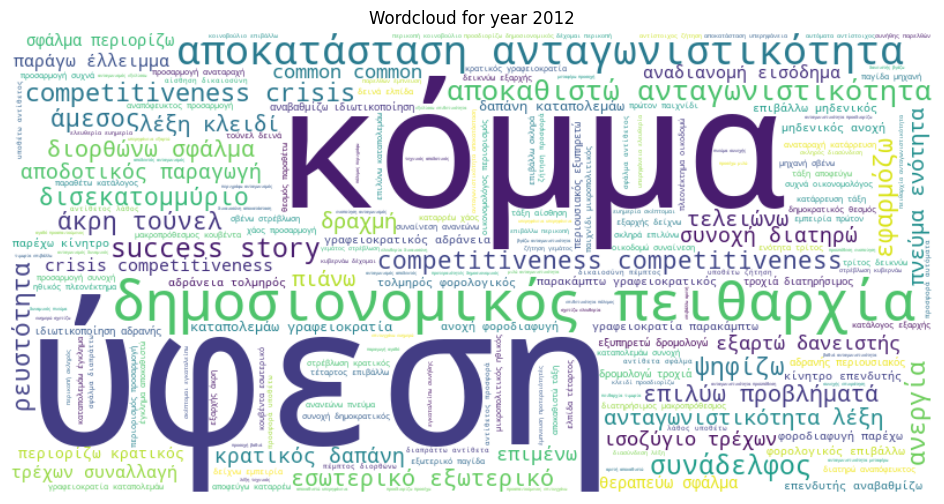

In [68]:
# create world clouds per year
from wordcloud import WordCloud

for year in data_df['year'].unique():
    text = ' '.join(data_df[data_df['year'] == year]['processed_text_str'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud for year {year}')
    plt.show()

In [71]:
from sklearn.feature_extraction.text import CountVectorizer

top_words = []

for year in data_df['year'].unique():
    text = data_df[data_df['year'] == year]['processed_text_str']
    cv = CountVectorizer(stop_words='english')
    X = cv.fit_transform(text)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    top_words.append((year, words_freq[:5]))
    
top_words

[('2024',
  [('πανεπιστήμιο', 107),
   ('εταιρεία', 68),
   ('εκλογή', 67),
   ('σχετικά', 59),
   ('αγρότης', 56)]),
 ('2023',
  [('φωτιά', 185),
   ('τετραετία', 169),
   ('τουρισμός', 167),
   ('περιφέρεια', 166),
   ('εκλογή', 162)]),
 ('2022',
  [('ενεργειακός', 382),
   ('ψηφιακός', 269),
   ('τουρισμός', 224),
   ('πηγή', 208),
   ('πόλεμος', 202)]),
 ('2021',
  [('εμβολιασμός', 668),
   ('ψηφιακός', 384),
   ('εμβολιάζω', 378),
   ('υφυπουργός', 259),
   ('γραμματέας', 256)]),
 ('2020',
  [('τουρισμός', 239),
   ('νησί', 213),
   ('νοσοκομείο', 181),
   ('ψηφιακός', 173),
   ('κορονοϊός', 166)]),
 ('2019',
  [('βουλευτής', 188),
   ('εκλογή', 136),
   ('ψηφίζω', 112),
   ('πλειοψηφία', 105),
   ('κόμμα', 99)]),
 ('2018',
  [('αναπτυξιακός', 207),
   ('μνημόνιο', 174),
   ('περιφέρεια', 163),
   ('παραγωγικός', 155),
   ('δημοσιονομικός', 150)]),
 ('2017',
  [('παραγωγικός', 252),
   ('περιφέρεια', 245),
   ('αναπτυξιακός', 195),
   ('παραγωγή', 164),
   ('σχεδιασμός', 163)]),
 